Install this stuff first:

```
install.packages("scrm")
install.packages("https://github.com/YingZhou001/popdemog/raw/master/POPdemog_1.1.tar.gz", repos=NULL)
install.packages("tidyverse")
install.packages("glue")
```

In [1]:
library(scrm)
library(POPdemog)
library(tidyverse)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne) { Ne / Ne0 }
scale_migr <- function(m) { 4 * m * Ne0 }

In [8]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 10000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 200
n_nea <- 4

n_haplotypes <- 1000
hap_length <- 10001

# split between MH and Neanderthals
T_nea_mh_split <- 600000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 70000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

# EUR <-> AFR migration rates (Gravel et al., PNAS 2011)
m_afr_bottle <- 15e-5
m_afr_eur <- 2.5e-5

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 500
m_nea_admix <- 0.0015

# mutation rate per site per generation
mut_rate <- 2.5*10^-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1*10^-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

### Compose the `scrm` command line string

In [9]:
scrm_cmd <- glue(

"{n_afr + n_eur + n_nea} {n_haplotypes} \\
-I 3 {n_afr} {n_eur} {n_nea} \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 3 {scale_Ne(Ne_nea)} \\
-em {scale_time(T_nea_admix_end)} 2 3 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 3 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck)} \\
-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 3 1"

)

In [10]:
paste("scrm", scrm_cmd)

[1] "scrm 404 1000 -I 3 200 200 4 -r 4.0004 10001 -t 10.001 -n 3 0.1 -em 0.0545 2 3 60 -em 0.055 2 3 0 -en 0.055 2 0.2 -ej 0.07 2 1 -ej 0.6 3 1"

### Check that the demographic model looks reasonable

There are  5 time events for  3  populations
read N and g, done!
read m, done!
read pos and update, done!
demographic initiation, done!
plot initiation, done!


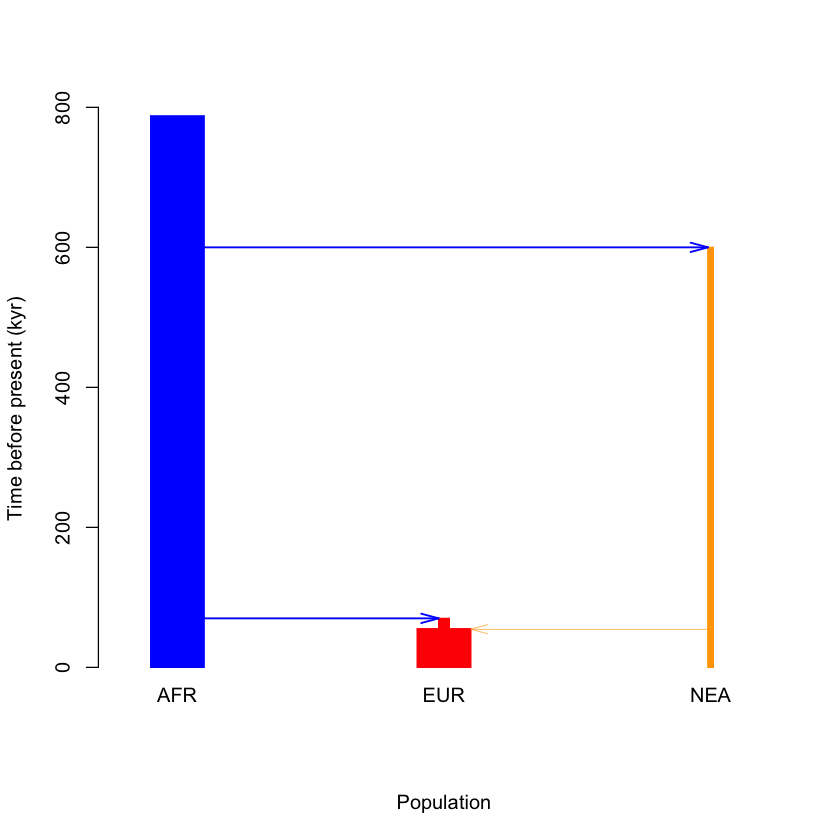

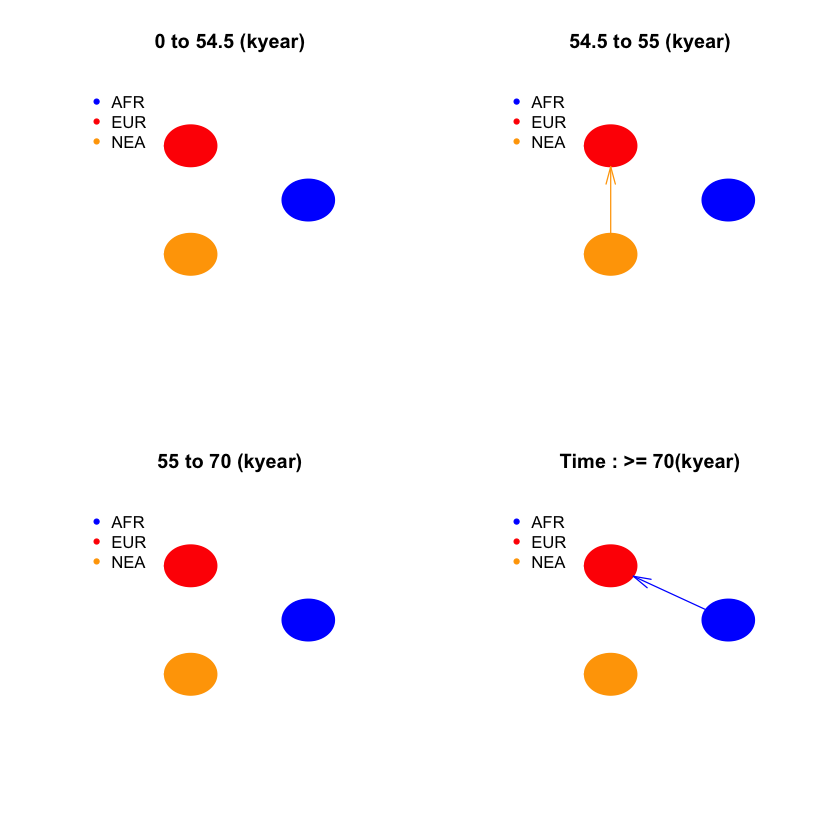

In [12]:
PlotMS(scrm_cmd, type="scrm",
       pops=c("AFR", "EUR", "NEA"),
       col.pop=c("blue", "red", "orange"),
       time.scale="kyear", N4=4*Ne0,
       demo.out=TRUE) -> plot_out
PlotMMig(demograph_out=plot_out$demograph_out, mig_par=plot_out$mig_par)

### Run the simulation and extract the matrix with simulated haplotypes

In [13]:
sim_res <- scrm(scrm_cmd)

In [15]:
# generate column names for the output df
col_names <- c(paste0("afr_", 1:n_afr), paste0("eur_", 1:n_eur), paste0("nea_", 1:n_nea))

In [16]:
# extract matrices with simulated haplotypes and set the column names
haplotypes <- map(sim_res$seg_sites, ~ .x %>% t %>% as_tibble %>% setNames(col_names))
all_sites <- bind_rows(haplotypes)

### "Design" the archaic admixture array
Keep only those sites that are nearly fixed in Africans, and fixed for a different allele in the Neanderthals (ignore the derived/ancestral state).

**To make testing easier, I'm requiring the African allele to be fixed! This will be changed later.**

In [17]:
# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

In [18]:
calc_freq <- function(df, pop, n) {
    all_sites[str_detect(col_names, pop)] %>% rowSums / n
}

In [19]:
afr_freq <- calc_freq(all_sites, "afr", n_afr)
nea_freq <- calc_freq(all_sites, "nea", n_nea)

In [20]:
array_sites <- filter(all_sites,
                      (afr_freq == 0 | afr_freq >= afr_cutoff) &
                      (nea_freq == 0 | nea_freq == 1) &
                      (abs(afr_freq - nea_freq) > 0.5))

What are the observed site patterns in Africans and Neanderthals? There should be only two:

In [21]:
distinct(select(array_sites, -starts_with("eur")))

afr_1,afr_2,afr_3,afr_4,afr_5,afr_6,afr_7,afr_8,afr_9,afr_10,⋯,afr_195,afr_196,afr_197,afr_198,afr_199,afr_200,nea_1,nea_2,nea_3,nea_4
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,0,0,0


### Detect Neanderthal introgressed alleles in simulated Europeans

Detect all Neanderthal alleles in the non-African population (TRUE/FALSE at each site converted to integers - 1 is Nea-like allele, 0 is an African-like MH allele):

In [22]:
introgressed_snps <- map_df(select(array_sites, starts_with("eur")), ~ as.integer(. == array_sites$nea_1))

What are the leves of Nea. ancestry in non-African haplotypes?

In [23]:
select(introgressed_snps, starts_with("eur")) %>% summarise_all(mean)

eur_1,eur_2,eur_3,eur_4,eur_5,eur_6,eur_7,eur_8,eur_9,eur_10,⋯,eur_191,eur_192,eur_193,eur_194,eur_195,eur_196,eur_197,eur_198,eur_199,eur_200
0.03440651,0.03069167,0.04104016,0.0287458,0.0347603,0.02945339,0.02060853,0.03334513,0.02927649,0.03192995,⋯,0.03546789,0.03865204,0.04360517,0.03935963,0.03759066,0.02343888,0.0349372,0.035291,0.03016098,0.0254732


### Check the SFS of introgressed alleles

In [25]:
(introgressed_snps %>% rowSums / n_eur) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.03331 0.04000 0.86000 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


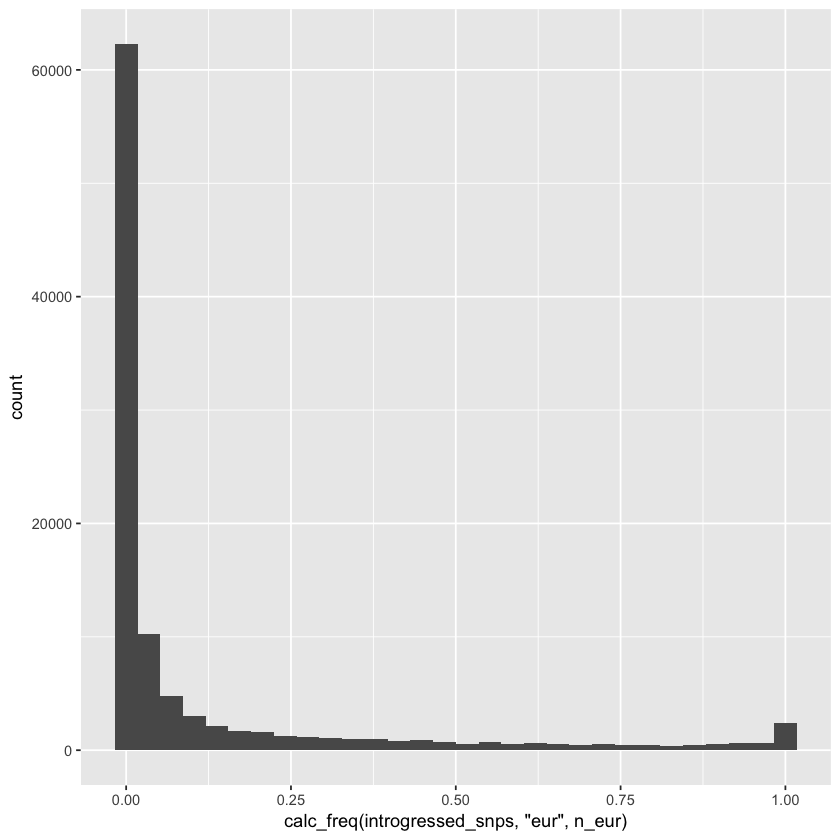

In [26]:
qplot(calc_freq(introgressed_snps, "eur", n_eur))